In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
data = pd.read_csv("fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv") # the path could change in online notebook
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values("Date", inplace=True)
data.reset_index(inplace=True)
data.drop(["index", "ID"], axis=1, inplace=True)

data["Data_Value"] = data["Data_Value"] / 10 # convert tenths of degrees C to degrees C

data.head()

,Date,Element,Data_Value
0,2005-01-01,TMIN,0.0
1,2005-01-01,TMAX,15.0
2,2005-01-01,TMIN,-1.1
3,2005-01-01,TMIN,-4.4
4,2005-01-01,TMAX,3.3


In [7]:
# filtering the data and deleting the 29 of febrary of the leap years
data = data.query("Date != ['2008-02-29', '2012-02-29']")
# add a day and month col for grouping
data["day"] = data["Date"].dt.day
data["month"] = data["Date"].dt.month

data2005_2014 = data.query("'2005-01-01' <= Date <= '2014-12-31'").copy()

data2015 = data.query("'2015-01-01' <= Date <= '2015-12-31'").copy()

In [8]:
# grouping the data for days and take the min and max for each day
MinMax2005_2014 = data2005_2014.groupby(["month", "day"])["Data_Value"].agg(["min", "max"])

MinMax2015 = data2015.groupby(["month", "day"])["Data_Value"].agg(["min", "max"])

# getting the outliers from 2015
def MinFilterFunc(row):
    date = row.name
    row = row.drop("max")
    if row["min"] < MinMax2005_2014.loc[date, "min"]:
        return row
    else:
        row["min"] = None
        return row

    
def MaxFilterFunc(row):
    date = row.name
    row = row.drop("min")
    if row["max"] > MinMax2005_2014.loc[date, "max"]:
        return row
    else:
        row["max"] = None
        return row
    
MinOutlaiers = MinMax2015.apply(MinFilterFunc, axis=1).copy().dropna()
MaxOutlaiers = MinMax2015.apply(MaxFilterFunc, axis=1).copy().dropna()
for i, _ in MinOutlaiers.iterrows():
    MinOutlaiers.loc[i, "dayofyear"] = pd.Timestamp(year=2015, month=i[0], day=i[1]).dayofyear

for i, _ in MaxOutlaiers.iterrows():
    MaxOutlaiers.loc[i, "dayofyear"] = pd.Timestamp(year=2015, month=i[0], day=i[1]).dayofyear
    

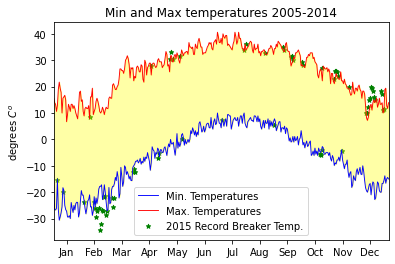

In [74]:
plt.figure(facecolor="w")
plt.ylabel("degrees $C^o$")
plt.title("Min and Max temperatures 2005-2014")
plt.plot(np.arange(1, 366), MinMax2005_2014["min"], "-", color="blue", linewidth=0.9)
plt.plot(np.arange(1, 366), MinMax2005_2014["max"], "-", color="red", linewidth=0.9)
plt.scatter(x=MinOutlaiers["dayofyear"], y=MinOutlaiers["min"], s=20, c="green", marker="*")
plt.scatter(x=MaxOutlaiers["dayofyear"], y=MaxOutlaiers["max"], s=20, c="green", marker="*")
plt.legend([
    "Min. Temperatures", 
    "Max. Temperatures", 
    "2015 Record Breaker Temp."
])

axes = plt.gca()

axes.fill_between(range(1, 366),  MinMax2005_2014["min"], MinMax2005_2014["max"], color="yellow", alpha=0.35)

# change the x axis labels for months
axes.set_xlim(1, 365)
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes.set_xticks(np.arange(15, 350, step=30))
axes.set_xticklabels(labels)


# plt.savefig("plot.png", dpi=600)
plt.show()